 <center><font size="6">Mask R-CNN Model Training and Export
 
 Isabelle Baker, UMich Research Jupyter Notebook

v2.3

I am an undergraduate student working on a research project at my university. As part of my responsibilities, I was asked to find a method for removing a 'dynamic' background in a set of videos which include animals, leaving behind only the animals. After searching around for solutions, including how make the [matterport Mask R-CNN](https://github.com/matterport/Mask_RCNN) code work natively on my Mac M2, I stumbled upon a [youtube video](https://www.youtube.com/watch?v=9a_Z14M-msc) explaining how to work with Meta's detectron2. Detectron2 was immediately appealing and made me realize that the problem statement I was working with needed to be adjusted. I mentally changed my assignment to "given a video with animals in it, return only the animals without any other background content." This may sound the same as my original assignment, but to me, the subtle difference in thought process was significant. So I decided to train and use detectron2 as the base for identifying the animals in my videos, creating instance masks, extracting the animals from videos based on these masks, pasting them onto a blank canvas, and then ultimately saving the newly constructed canvas as a video frame in a new video.  

To make this notebook and learn about Machine Vision model I studied a lot sources scattered around the internet. Therefore, let me know if you see something that look like your code without acknowledgment and I am happy to include a reference. 

I have included the lessons and methods I learned during this process, even if they were not strictly related to my original goal. I spent **A LOT** of time researching solutions to what seemed like simple problems with detectron2 and Colab, which ultimately required rather complex solutions. I sincerely hope this notebook helps someone else save time in the future! If you find something I am missing, let me know and I'll include it as I have time.

Within this notebook, I will: 

1.   Explain how to get your dataset ready to train your model. 
2.   Give the code required to train your model, including the flexibility to train an individual thing, or many things, automagically with a simple change to configuration parameters. 
3.   Create inference output with images using your new model.
4.   Export the model to torchscript format for portability. 

Problems I had to solve:
1.  Hacking together a static version of the core training/inference code was relatively easy. Making it generic so that I/you can make zero/minimal code changes and train 1 to N classes, took a lot of effort. This was the main reason I have this notebook's Global Variables at the start of code sections. Make sure you understand these variables and their usage before modifiying the code in the notebook. 
2. I only found 1 sample of code explaining how to take an instance mask and use it to get only that object back out of an image. I ended up creating a new framework for use with my research. More on that later.
3. I did not find any working examples of subclassing the default trainer to add the augmentations. One example was close to working, but its info needed to be completed. My functional example is shown below in the MyTrainer class. In addition, I have added the augmentation list to the Global Variables so that it can be easily modified for your purposes.
4. Auto-saving the newly created model out of colab. This may sound minor, but it is vital when trying to conserve compute credits. I save a time/date marked version of the model and model configuration to my Google drive. At the end of the code, there is an auto-terminate function to delete the runtime and stop consuming credits. You should be abler to adjust the Global Variables while offline and then connect the runtime, hit run-all, and walk away knowing that it won't waste your compute credits. You can change one of the Global Variables if you and stay connected after training if that is your desire.
5. I could not find any *simple* method to display only the thing classes I wanted. The objective is that regardless of what was detected, only mask and highlight certain classes of things. All of the examples I read showed filtering to a single classes or not at all, but I implemented a method to filter N classes. This is done by recursively removing all detected things that are not in the un-ordered "my_display_things" list. Three lines of code accomplish what seemed very complex initially. However, as this notebook evolved, I have moved that specific functionality over to my framework in GitHub.  
6. I did not locate any complete examples of preparing a dataset from start to finish. The data preparation section of this doc may seem excessively detailed, but it comes from frustration at not finding a good tutorial.
7. An ***EASY*** way to export a pytorch model to torchscript from detectron2. Every tutorial I found made it overly complicated. This a tiny bit of customization in code borrowed from detectron2, it's very simple. 
8. A way to 'batch' load images into an exported torchscript model. This is really subtle in this notebook but the export_scripting method that I use is slightly modified from the code in detectron2. I have changed Tuple to List in the forward function.  I could just never figure out how to build Tuple[Dict[str, torch.Tensor]] so I changed it to List[Dict[str, torch.Tensor]]. Like magic it worked. If anyone ready this understands how to make the original structure and load multiple images/frames simultaneously please let me know.   
9. I will add more items here as I remember additional challenges I encountered and solved.    


Happy training!

<font size = '2' color='red'>*This was the actual goal of my work when I started.</font>

# Before You Begin
---

## Preparing Your Dataset

Every tutorial I have read for detectron2, and machine vision in general, waves its virtual hands and says, "make sure to prepare and annotate your images properly." Below I explain exactly how I prepared and annotated the images. I have included everything that seemed critical without being overly verbose. 

### Find Your Images

I needed to acquire and annotate images of rats and larvae. To acquire the larva images, I leveraged some videos we had from our lab. I extracted a variety of frames from differing sets of videos and stored them for processing. Acquiring quality rat images proved more difficult. First, I downloaded as many as I could find from the internet. Then I grabbed a few out of Adobe stock (yes, I did it legitamately). Image acquisition will always be a hurdle to improving detection quality if this project is taken forward. 

### Annotate Your Images

#### Create the Project and Task(s)

For image annotation, I used the online version of [CVAT](https://app.cvat.ai/). It is free to use, and the only downside I have found so far is that you can only have three projects in the free version. However, that is plenty for my purposes because you can also save/update image-annotation pairs. Provided that you are organized with your local dataset storage, it is easy to rotate in and out projects by re-uploading the images, setting up the labels in the project just like the original, and uploading the existing annotations. Therefore, for my annotating tasks, I used CVAT and exported it to "COCO 1.0" format for simplicity<font color='green'>*</font>. 

To start, create a project and add the labels you want, as shown in Figure 1. 

For my project, I used polygons for the annotation type as shown in Figure 2.

Then create a new Task, as shown in Figure 3. Upload all of the images that you want to annotate. After creating the task, open it and start annotating!
___
<font color='green' size='2'>*Detectron2 includes a COCO format dataloader. Therefore, using the COCO 1.0 format makes it very easy to import the annotations.</font>


Figure 1: Create a Project and Create Needed Labels

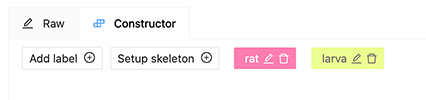
___

Figure 2: Create the needed labels

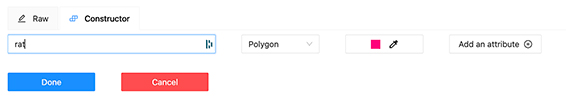
___

Figure 3: Create New Task

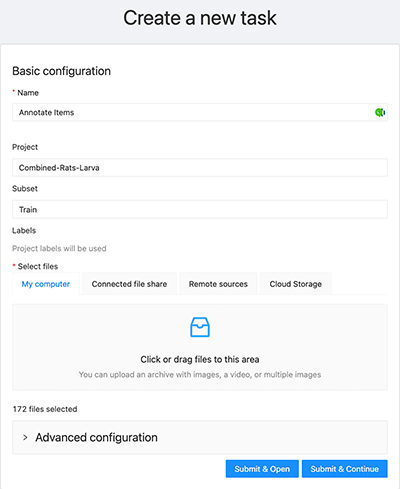
___

#### Draw the annotations

Now it is time to draw on your image. Fun, right? Not exactly. It is incredibly monotonous. I look forward to the day when I can outsource this to some unsuspecting undergrad ;)

The first way to label is by selecting the pentagon shape on the left side toolbar and adding points around the object you want to capture. Next, make the polygon points fit the object closely by zooming in/out and moving around in the image. 

<font size="2">ProTips:</font>

*  <font size='2'>'N' starts/ends an annotation</font>
*  <font size='2'>'F' goes to the next image</font>
*  <font size='2'>{Fn}{Del} completely deletes the highlight annotation on my Mac. I deleted and re-annotated many times and got sick of using the menus to delete. So that you know, the key-combo CVAT suggests didn't work on my Mac.</font>
*  <font size='2'>To quickly draw a LOT of points, press 'N' to start a new polygon as usual. Then hold the {shift} key and move the mouse over the object's edge. It will {auto-draw} points as if you repeatedly click the mouse button. You can let go of the {shift} key, reposition the cursor or mouse, and then press the {shift} key to add more points. Terminate the polygon by presssing 'N' again. You should note that the more zoomed into the image you are, the more actual points it adds. I have included an example below to show the difference in the quality of annotation. *In theory,* you could produce the same results manually clicking each point, but you would quickly end up with a repetitive stress injury. Play around with this capability. It is quite useful.</font>
*  <font size='2'>If you want to get fancier, I would suggest using the magic wand tool on the left toolbar but remember: ensure that "convert masks to polygons" is on, as shown in Figure 4! The HRNET and F-BRS algorithms worked best for me. If you are going to use these tools, go slowly. Click within the object, wait to see the result, and then click again if needed. After it makes the majority of the shape, go to an area that needs refinement and {shift}{click} on a point. Then add a new line segment. You must {click} on an existing point to terminate that new line segment. The behavior is sometimes unexpected as it selects which part of the polygon to keep. If it flashes back and forth between to colors (red and blue in my case), it is asking you to tell it which shape you intended to make. {Click} the one you want.   
*  <font size='2'>My magic mouse with my Mac was a nightmare. The zooming on the mouse would engage when I least expected it. I went into the System Setting -> accessibility->pointer control->mouse option and disabled "use mouse for scrolling." Then I used my left hand on the trackpad to zoom in/out and the magic mouse just for annotating.</font>

Make sure to save your work as you complete annotation of an image. It is better to save too often rather than risk the furstration of accidentally closing the browser window without saving your work! *I do not want to talk about why I know this is frustrating.*

Before:

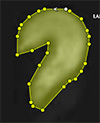

After using the continuos point method:

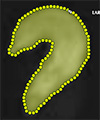

___

Figure 4: Magic Wand

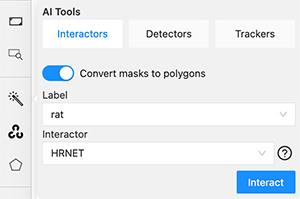
___

####Export Your Annotations

Once you finish your annotations, go back to the projects page. Hover over the three vertical dots in the lower right corner of your project and click "Export Dataset."  Then select "COCO 1.0" format, give the file a name, and click download. This final screen is shown in Figure 5. 

Once this file downloads, you will notice it is a zip file. Once extracted, it will contain up to three annotation files: One for training, one for testing, and one for validation.  If you have only created a single training annotation set, it will only have a single file inside the zip. 

Move the annotation file(s) to the proper folder within your dataset and then you are ready to train!

Figure 5: Annotation Export

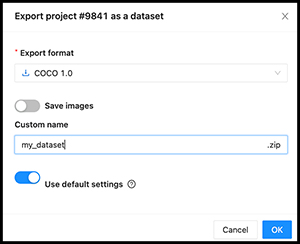

___

## Setup Your Dataset Directory Structure in Google Drive

You <font color="red">must</font> follow the dataset directory structure shown below, or you will need to change this code. First, I put the datasets' root at the root of my google drive for simplicity. Then I put each dataset inside a folder as shown below:

    GoolgeBase (aka: MyDrive)
        |
        datasets
            |
            my_dataset_path
                |
                train
                  |
                  {your_training_images}
                |
                test
                  |
                  {your_test_images}
                |
                annotations
                  |
                  {your_annotation_files}
                |
                videos
                  |
                  {your_video_files (mp4, mov, avi only}
                videos_output
                  |
                  {your_video_processing_results_will_go_here}
                |
                models
                  |
                  {timestamped_model_copies_stored_here}
                |
                logs {auto-created}
                  |
                  {training logs go here}
                |
                sys {optional}
                  |
                  {any local libraries, functions, etc.,}

___

# Setup the Notebook and Install Detectron2 (v0.6)
---



The following installs everything required for Meta's detectron2 in Google Colaboratory. If you want to do a local installation I have a seperate document in my Github that walks through that process. The local installation is a bit involved, but I walk through the steps for MS Windows 10, MacOS on Intel, and MacOS on Apple Silicon (M1/M2). As of the time that I am writing this, pytorch still isn't supporting enough functions/methods/capabilities to use GPU acceleration with detectron2 in Apple Silicon. Hopefully by the time you read this, that will change. 

##Mount your Google Drive

These commands mount your google drive as '/content/drive' within your Colab notebook. Therefore, if you put your datasets within your google drive, they are easy to access while the notebook is active. 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get the Correct version of opencv

There is/was a bug in some recent versions of OpenCV, so we need to downgrade to a specific version. The bug causes 'rotated' video from sources such as a phone or GoPro to not be output correctly. It was a minor cosmetic issue but still kind of annoying. I *think* the latest released version fixed the issue, as my stand alone framework doesn't require this older opencv. 

In [2]:
opencv_version = !pip show opencv-python | grep Version
if opencv_version[0] != 'Version: 4.5.5.64':
  !pip uninstall opencv-python --yes
  !pip install opencv-python==4.5.5.64
else:
  print('opencv ' + opencv_version[0] + ' already installed')

opencv Version: 4.5.5.64 already installed


##Install pyyaml, torch, and torchvision 

Note: You will likely see an error for torchaudio and torchtext compatibility. You can safely ignore these messages for this project. I don't use either torchaudio or torchtext so I don't bother to download and install the correct versions.

In [3]:
# Check which versions of pyyaml, torch, and torchvision are installed.
# If the versions you want are not installed, do it now.
# If they are installed, don't waste time downloading them.
pyyaml_version = !pip show pyyaml | grep Version
torch_version = !pip show torch | grep Version
torchvision_version = !pip show torchvision | grep Version

!pip install pyyaml
if torch_version[0] != 'Version: 1.10.1+cu113':
  !pip install torch==1.10.1+cu113 -f \
    https://download.pytorch.org/whl/torch_stable.html
else:
  print('torch ' + torch_version[0] + ' already installed')
if torchvision_version[0] != 'Version: 0.11.2+cu113':
  !pip install torchvision==0.11.2+cu113 -f \
    https://download.pytorch.org/whl/torch_stable.html
else:
  print('torchvision ' + torchvision_version[0] + ' already installed')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch Version: 1.10.1+cu113 already installed
torchvision Version: 0.11.2+cu113 already installed


##Install Detectron2

In [4]:
# Check which version of detectron2 is installed.
# If the version I want is not installed, do it now.
# If it is installed, do not waste time downloading it. 
detectron2_version = !pip show detectron2 | grep Version

if detectron2_version[0] != 'Version: 0.6+cu113':
  !python -m pip install detectron2==0.6 -f \
    https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
else:
  print('detectron2 ' + detectron2_version[0] + ' already installed')

detectron2 Version: 0.6+cu113 already installed


That is it. Your notebook should be all setup and ready to start understanding 
the world around it.

## Get Info About Your Environment
---

I like to include this to see what resources I am using to train the model. That way, if something is taking longer than I expect I can valudte that I properly set the runtime type. 

In [5]:
!nvidia-smi
!lscpu |grep 'Model name'

Thu Apr 13 18:36:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import The Required Libraries
---

In [6]:
# If you want to import modules stored in local files, you must add
# the directory storing the modules to the system path first.
# My suggestion is to create a "sys" directory within your dataset structure 
# and then add it to the path. For instance, you could put the thing_masker cell
# into a thing_masker.py file and store it separately. 
#
#import sys
#sys.path.append(my_dataset_path + my_dataset_name)
#sys.path.append(my_dataset_path + my_dataset_name + '/sys/')
#


import os
import time
import torch 
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime 
import shutil

from IPython.display import display
from IPython.display import Image as IPython_Image

# Import Detectron2 libraries.
import detectron2
from detectron2 import model_zoo, data
from detectron2.config import get_cfg, LazyConfig
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.colormap import random_color
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.engine.train_loop import weakref
from detectron2.data import DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.build import build_detection_train_loader

from tqdm.notebook import tqdm_notebook
from google.colab.patches import cv2_imshow
from google.colab import runtime

from torch import Tensor, nn
from typing import Dict, List
from detectron2.structures import Boxes
from detectron2.utils.env import TORCH_VERSION
from detectron2.modeling import GeneralizedRCNN
from detectron2.utils.file_io import PathManager
from detectron2.utils.visualizer import Visualizer
from detectron2.export import (
    dump_torchscript_IR,
    scripting_with_instances,
)

# Tell matplotlib to display within the notebook.
%matplotlib inline

# GPU support configuration.
# This line checks to see if you have cuda, apple mps, or just cpu.
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

#<font color='red'>Set up Your Global Variables Here! Modify this section</font>
---

In [7]:
#
#  my_dataset_path = path to where all of your datasets are stored
#  my_things = ['thing1', 'thing2', etc.]
#  my_dataset_name = 'your_dataset_name'
#  my_training_annoation_name = "name_of_the_annotation_file_you_want_to_use"
#

#  my_dataset_path = path to where all of your datasets are stored.
my_dataset_path = '/content/drive/MyDrive/datasets/'

# inference size: for most of the animals we overfit based on the samples.
# this tells what size the training images will be and therefore what size
# the inferencing should be conducted at in the future.
my_inference_size = 256

#  my_things = ['thing1', 'thing2', etc] are the things in the model. 
my_things = ['larva',]


# my_display_things = ['thing1', 'thing2', etc.] are the things you want to 
# visualize. This should be everything in your model during training.  
# The output only includes items in this unordered list. This is no longer
# used in this notebook but it IS used in the standalone framwork.
my_display_things = ['larva',]

# my_prediction_threshold is a float <= 1.0 that defines the minimum
# prediction probability accepted as a valid result for the model output.
# If you are training for the first time, set this VERY low to see all
# detections. Refine as the model accuracy improves to ensure fewer false
# identifications.
my_prediction_threshold = 0.5

# Your folder name within "datasets" that you are storing your dataset info.
my_dataset_name = 'combo_v2'

# Name of the annotation file to use for training. 
my_training_annotation_name = 'larva_only_annotations.json'

# Set the image and video file extensions you want to support for testing.
# The target testing directory will be searched for files with these extensions.
# My Mac stores .DS_Store files everywhere that cause issues unless I filter 
# them out! Out of nowhere, I get an empty image/tensor and spend FOREVER
# tracking down the source without this filter.
image_extensions = ['.jpg','.png',]
video_extensions = ['.mp4','.mov', '.avi',]

# List of augmentation used to train a new model. This is used within
# MyTrainer(). Read below about my success/failure using augs.
#my_augmentations = [T.ResizeShortestEdge(short_edge_length=(160, 320, 640), max_size=1333, sample_style='choice'),
#                    T.RandomRotation(angle=[0,180],sample_style="range"),
#                    T.RandomFlip()]

# How many iterations to train.
# FYI: with the parameters in this notebook and the dataset I provide,
# the model stops improving at approx 20,000 iterations. (160,000 images) 
# Interesting Fact: #_Epoch = (IMS_Per_Batch/#_of_images)*max_iterations
# I include this in case you want a comparison to other metrics in ML.
my_max_iterations = 200 #20000

# I use 4 for Standard GPU (Tesla T4) and 8 for Premium (A100-40G). 
my_IMS_PER_BATCH = 4 #8

# Flag causes the runtime to "Disconnect and delete" at the end of   
# 'run all' to save compute credits. **if errors occur it will stay connected**
# Ensure you really want the runtime and all local info to be terminated.
# I left this defaulted to "True" so all the people running it who don't 
# read this far won't waste resources.
disconnect_on_complete = True

# Train The Model
---

##<font size="4">Import Dataset

<font size='3'>

1. Import the annotations you made (coco format, polygon).
2. Register the dataset with the correct category name using the detectron2 coco dataloader.
3. Point the instance to the image directory.
4. Check that the 'things' inside the annotations match the 'things' you configured.

In [8]:
# Import the images and annotations.

# Check if the dataset name is already registered. If so, remove.
# This shouldn't happen normally, but while debugging and running the notebook
# repeatedly, this happens so I decided to catch/fix it. 
if str(my_dataset_name + '_train') in DatasetCatalog.list():
    DatasetCatalog.remove(str(my_dataset_name + '_train'))

# Register the dataset.
register_coco_instances(str(my_dataset_name + '_train'), {}, \
                        str(my_dataset_path + my_dataset_name + \
                            '/annotations/' + my_training_annotation_name),
                            str(my_dataset_path + my_dataset_name + '/train'))

my_dataset_metadata = MetadataCatalog.get(str(my_dataset_name + '_train'))

dataset_dicts = DatasetCatalog.get(str(my_dataset_name + '_train'))

current_time = datetime.now()

# This date_time structure looks complicated but it's done this way so that 
# I can tightly control exactly what is used and the delineator
date_time = f'_{str(current_time.month)}_{str(current_time.day)}_{str(current_time.year)}_{str(current_time.hour)}_{str(current_time.minute)}_{str(current_time.second)}'

# Check to be sure that the things in the annotations 
# match the things manually entered in the Global Variables above.
# A mismatch will cause confusion later. 
class_names = MetadataCatalog.get(str(my_dataset_name + '_train')).thing_classes
if (class_names != my_things) and train:
  print('Your annotations and the classes you listed do not match!')
  print('In Annotations: ' + str(class_names))
  print('You entered: ' + str(my_things))
  assert class_names != my_things, 'Check your things!'


##<font size="4"> Ensure Annotations Look Correct

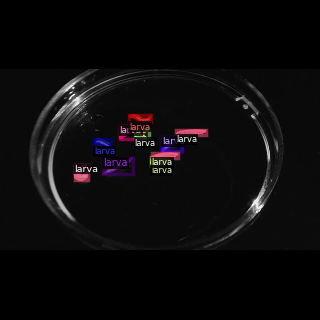

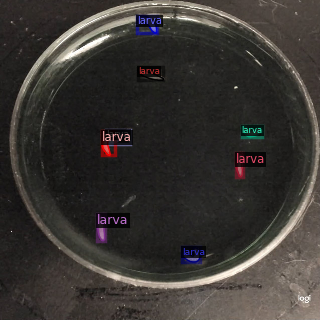

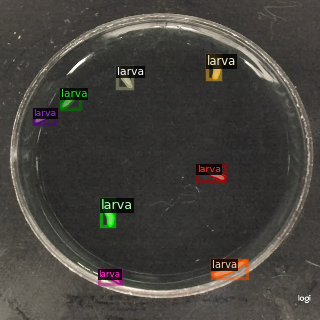

In [9]:
# Verify that the annotation data is loading correctly.
# Visualize three randomly selected samples in the training dataset.
# You can change the "scale=0.5" to something larger if you want
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], \
                            metadata=my_dataset_metadata, scale=0.5) 

    # Draw the annotation onto its associated image.  
    vis = visualizer.draw_dataset_dict(d)

    # Display the result.
    cv2_imshow(vis.get_image()[:, :, ::-1])

##<font size="4">Create Detectron2 Configuration For Training.



<font size="4">This config starts with the mask_rcnn_R_50_FPN_3x config and weights and then builds from there.  

In [10]:
# FYI: in detectron2, epochs = (MAX_ITER * IMS_PER_BATCH) / TOTAL_NUM_IMAGES

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR=my_dataset_path + my_dataset_name + '/logs/'
cfg.DATASETS.TRAIN = (str(my_dataset_name + '_train'),)
cfg.DATASETS.TEST = (str(my_dataset_name + '_train'),)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")                    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# This should equal the number of things you have in your annotations.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = int(len(my_things)) 
cfg.MODEL.RETINANET.NUM_CLASSES = int(len(my_things))
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = int(len(my_things))
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = int(len(my_things))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.DATASETS.TEST = (str(my_dataset_name + '_train'),)
cfg.INPUT.MIN_SIZE_TEST = my_inference_size
cfg.INPUT.MAX_SIZE_TEST = my_inference_size
cfg.INPUT.MIN_SIZE_TRAIN = my_inference_size
cfg.INPUT.MAX_SIZE_TRAIN = my_inference_size

##################
# Solver options #

# Set the maximum iterations.  
cfg.SOLVER.MAX_ITER = my_max_iterations

# This is your base learning rate after the warmup period.
cfg.SOLVER.BASE_LR = 0.001

# Warmup iterations linearly ramp learning rate from zero for the first 10%
# of iterations.
cfg.SOLVER.WARMUP_ITERS = int(my_max_iterations*.1)    

# Iteration steps at which to decay the learning rate.
# Set at 40% and 80% of total iterations.
cfg.SOLVER.STEPS = (int(my_max_iterations*.4),int(my_max_iterations*.8),)
cfg.SOLVER.GAMMA = 0.5

# Load 4 images in each batch. If you do not have enough memory for this 
# you can reduce down to 1. On Colab Pro, I use 4 for the standard GPU system 
# and I use 8 for the Premium GPU system.
cfg.SOLVER.IMS_PER_BATCH = my_IMS_PER_BATCH

cfg.MODEL.DEVICE = device


##<font size="4">Set up the dataset augmentations by subclassing the default trainer

I found a simple example of how to add augmentations to a dataset [here](https://stackoverflow.com/questions/71774744/how-to-use-detectron2s-augmentation-with-datasets-loaded-using-register-coco-in). This example needed to be completed with imports, etc. therefore I have completed it and made it available for training. A list of augmentations included with detectron can be found [here](https://github.com/facebookresearch/detectron2/blob/main/detectron2/data/transforms/augmentation_impl.py). However, I have not perfected the use of augmentations yet, so my final model that I included with this notebook was actually trained using the default trainer. You should play with the augmentations though and see if you can fine the right combination that improves your dataset/training. For me, what I was using made the model perform worse and I haven't had time to understand why. 

In [11]:
from detectron2.data import DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.build import build_detection_train_loader
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, \
                               augmentations = my_augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)

##<font size="4">Start Training

Now do the actual training and save a time/date marked copy of the model with its configuration used for training into the dataset's {models} folder. 

<font size='2'>Note: The model I included in the GITHUB was trained on colab pro using the "Premium" GPU (A100-SXM4-40GB) for 20,000 iterations, with a batch size of 8 and the included dataset. I played around with the parameters a bit and this produced the best result so far. It took approx 155 minutes costing approx $3.41 in Premium Colab compute credits. I'm happy with the preliminary results!

|images|iterations|IMS Batch|Base LR|  warmup | steps  | decay |
|:----:|:--------:|:-------:|:-----:|:-------:|:------:|:-----:|
| ###  |  20,000  |    8    | 0.001 |10% iter |40%, 80%| 0.5   |
|      |          |         |       |         |        |       |



In [12]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.makedirs(str(my_dataset_path + my_dataset_name + '/models/' + \
                my_things[0] + date_time), exist_ok=True)

# If you want to use custom Augmentations, comment out this line then uncomment
# the line after.                
trainer = DefaultTrainer(cfg)
#trainer = MyTrainer(cfg)

trainer.resume_or_load(False)
trainer.train()

# Save the model for when we close the notebook!
shutil.copy2(os.path.join(cfg.OUTPUT_DIR,"model_final.pth"), \
              str(my_dataset_path + my_dataset_name + '/models/' + \
                  my_things[0] + date_time + '/' + \
                  my_things[0] + date_time + '.pth'))

print("done training!")
with open(str(my_dataset_path + my_dataset_name + '/models/' + my_things[0] + \
              date_time + '/' + \
              my_things[0] + date_time + '.yaml'), "w") as f:
  f.write(cfg.dump())



[04/13 18:36:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/13 18:36:24 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.9/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/13 18:36:30 d2.utils.events]:  eta: 0:00:46  iter: 19  total_loss: 2.769  loss_cls: 0.5033  loss_box_reg: 0.8166  loss_mask: 0.6552  loss_rpn_cls: 0.3226  loss_rpn_loc: 0.3359  time: 0.2789  data_time: 0.0772  lr: 0.00095005  max_mem: 1131M
[04/13 18:36:36 d2.utils.events]:  eta: 0:00:41  iter: 39  total_loss: 1.481  loss_cls: 0.189  loss_box_reg: 0.6218  loss_mask: 0.3215  loss_rpn_cls: 0.1134  loss_rpn_loc: 0.2619  time: 0.2848  data_time: 0.0586  lr: 0.001  max_mem: 1131M
[04/13 18:36:42 d2.utils.events]:  eta: 0:00:36  iter: 59  total_loss: 1.129  loss_cls: 0.1398  loss_box_reg: 0.4554  loss_mask: 0.2442  loss_rpn_cls: 0.08293  loss_rpn_loc: 0.2108  time: 0.2875  data_time: 0.0570  lr: 0.001  max_mem: 1131M
[04/13 18:36:47 d2.utils.events]:  eta: 0:00:31  iter: 79  total_loss: 1.028  loss_cls: 0.1226  loss_box_reg: 0.3824  loss_mask: 0.2195  loss_rpn_cls: 0.07855  loss_rpn_loc: 0.2156  time: 0.2793  data_time: 0.0481  lr: 0.001  max_mem: 1131M
[04/13 18:36:54 d2.utils.events]: 

<font size='2' color="red">Note: You will see warning messages like this: 
"WARNING:fvcore.common.checkpoint:Skip loading parameter 'roi_heads...."

It is ok.  You are likely training with fewer classes than were originally in the mask_rcnn_R_50_FPN_3x model and it is complaining about it. so you can safely ignore the messages.</font>

##<font size="4">Evaluate the Model

You should be aware that I am cheating a bit here. I actually use the same dataset to train and test the model so this isn't a great representation of the true model performance. If you would like a better measure of actual model performance you'll need to change the datasets to be different than your training set. 

[This article](https://www.v7labs.com/blog/mean-average-precision) was a worthwhile read for understanding the output of the model evaluation. I'll admit, its ads are a bit annoying but the article itself is decent. 

In [13]:
evaluator = detectron2.evaluation.COCOEvaluator(str(my_dataset_name + '_train'),
                                                distributed=False, output_dir=cfg.OUTPUT_DIR)
val_loader = detectron2.data.build_detection_test_loader(cfg, str(my_dataset_name + '_train'))
print(detectron2.evaluation.inference_on_dataset(trainer.model, val_loader, evaluator))

[04/13 18:37:24 d2.data.datasets.coco]: Loaded 27 images in COCO format from /content/drive/MyDrive/datasets/combo_v2/annotations/larva_only_annotations.json
[04/13 18:37:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(256, 256), max_size=256, sample_style='choice')]
[04/13 18:37:24 d2.data.common]: Serializing 27 elements to byte tensors and concatenating them all ...
[04/13 18:37:24 d2.data.common]: Serialized dataset takes 0.32 MiB
[04/13 18:37:24 d2.evaluation.evaluator]: Start inference on 27 batches
[04/13 18:37:25 d2.evaluation.evaluator]: Inference done 11/27. Dataloading: 0.0011 s/iter. Inference: 0.0457 s/iter. Eval: 0.0104 s/iter. Total: 0.0572 s/iter. ETA=0:00:00
[04/13 18:37:26 d2.evaluation.evaluator]: Total inference time: 0:00:01.285777 (0.058444 s / iter per device, on 1 devices)
[04/13 18:37:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.044029 s / iter per device, on 1 dev

##<font size="4">Save the Animal Class List

In my software framework, I depend on having two files available for the model.
1. The model itself in *.ts torchscript format (That export will happen a little later in this notebook)
2. A file providing the mapping between internal numerical animal id and the real world name of an animal. The file is just a text file with a dictionary converted into json format. It looks like this <font color='green'>{"0": "rat", "1": "larva"}</font> with key/value pairs for each trained animal.   

In [14]:
import json
class_list_names = str(my_dataset_path + my_dataset_name + '/models/' + \
                       my_things[0] + date_time + '/' + my_things[0] + \
                       date_time + '_class_list.txt')

class_names = my_things
class_list = {}
for i in range(len(class_names)):
    class_list[i] = class_names[i]

with open(class_list_names, 'w') as class_file:
    class_file.write(json.dumps(class_list))


##<font size="4">Export the model to torchscript

In order to export the model from pytorch within detectron2 into a more portable format, I *borrowed* some code from the detectron2 export function. The export_scripting method below is 99% a cut/paste from within a more complicated detectron2 class and then I slightly modified it to make batch inferencing work. 

In [15]:

def export_scripting(torch_model, modelname, output_path):
    assert TORCH_VERSION >= (1, 8)
    fields = {
        "proposal_boxes": Boxes,
        "objectness_logits": Tensor,
        "pred_boxes": Boxes,
        "scores": Tensor,
        "pred_classes": Tensor,
        "pred_masks": Tensor,
        "pred_keypoints": torch.Tensor,
        "pred_keypoint_heatmaps": torch.Tensor,
    }

    class ScriptableAdapterBase(nn.Module):
        # Use this adapter to workaround https://github.com/pytorch/pytorch/issues/46944
        # by not returning instances but dicts. Otherwise, the exported model is not deployable
        def __init__(self):
            super().__init__()
            self.model = torch_model
            self.eval()

    if isinstance(torch_model, GeneralizedRCNN):
        class ScriptableAdapter(ScriptableAdapterBase):
            def forward(self, inputs: List[Dict[str, torch.Tensor]]) -> List[Dict[str, Tensor]]:
                instances = self.model.inference(inputs, do_postprocess=False)
                return [instance.get_fields() for instance in instances]

    ts_model = scripting_with_instances(ScriptableAdapter(), fields)
    with PathManager.open(modelname, "wb") as file_pointer:
        torch.jit.save(ts_model, file_pointer)
    dump_torchscript_IR(ts_model, output_path)
    return None


In [16]:
predictor = DefaultPredictor(cfg)
model = predictor.model
detectron2.checkpoint.DetectionCheckpointer(model).resume_or_load(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))
model.eval()
# Create the exported model name and location
standalone_model = str(my_dataset_path + my_dataset_name + '/models/' + \
                       my_things[0] + date_time + '/' + my_things[0] + \
                       date_time + '.ts')

model_location = cfg.OUTPUT_DIR

# Export the scripted model
export_scripting(model, standalone_model, model_location)

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


# Test Your Model on Images!

Please be aware that we are testing the pytorch model and not the torchscript model. In order to test the exported torchscript model please launch the UI include with my software framework and load the appropriate directory containing the ts model and txt files. 

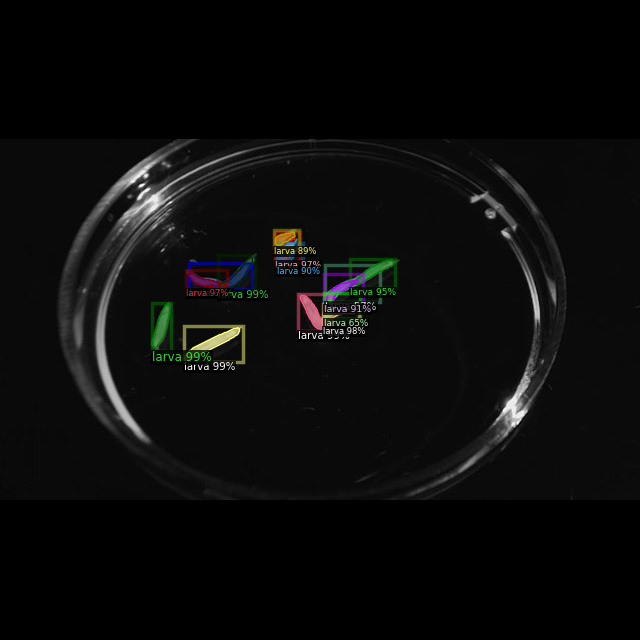

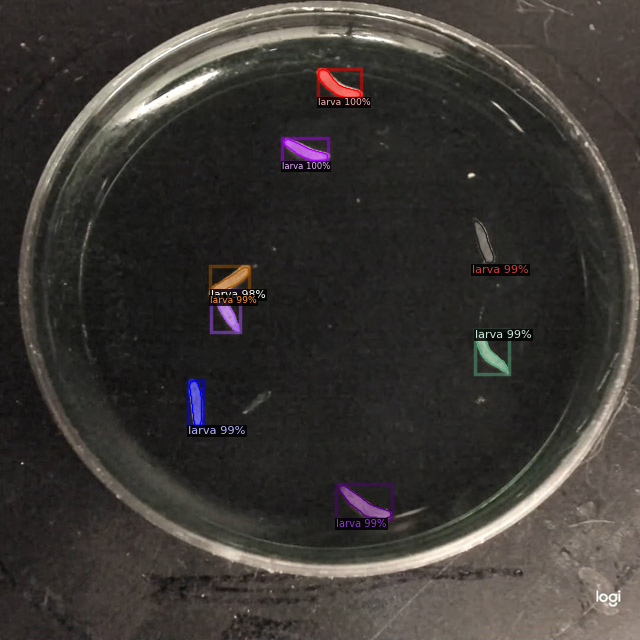

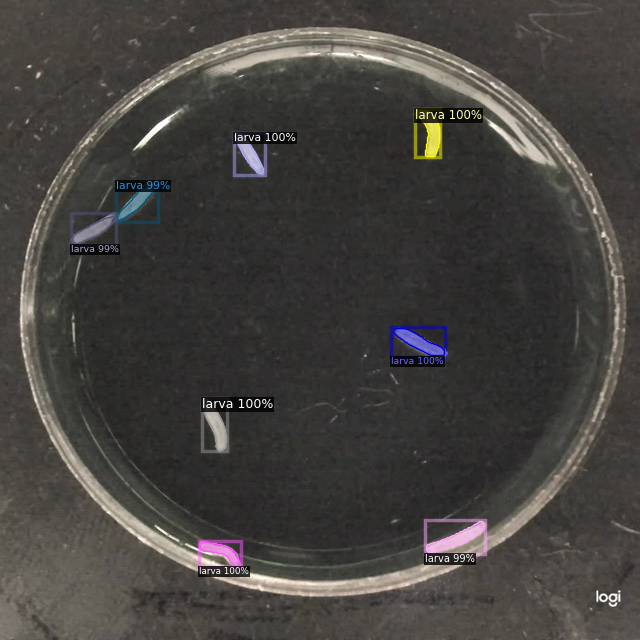

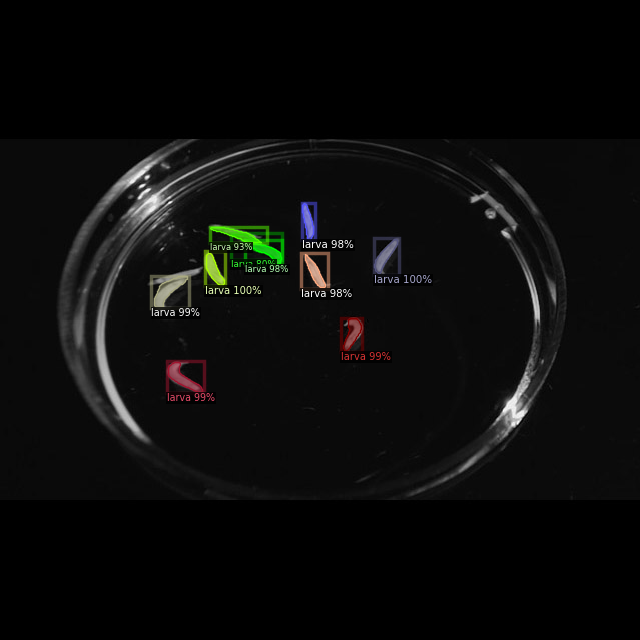

In [17]:
# Verify that the works correctly.  
# Note: This is the pytorch model and not the torchscript model
# To validate the torchscipt model please use the standalone software.
for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], \
                            metadata=my_dataset_metadata, scale=1.0) 

    # Draw the annotation onto its associated image. 
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu")) 

    # Display the result.
    cv2_imshow(out.get_image()[:, :, ::-1])

##<font size="4">How do I train again?!?

That's it. you have fully trained and exported your model. You'll find it in it's own date/time stamped folder so that you could immediately run another training session and it won't overwrite what you just did. 

That may not seem important, but I once used premium GPUs in Colab, trained for 4 hours, then accidentally started training again but with only 100 iterations. Before I realized what was happening, it overwrote my well trained model with a garbage one. My lesson is your gain!

<font color='red'>If you want to train again and change a lot of the parameters then I have some advice. 
1. Change the disconnect_on_complete variable to False. Run using your iitial set of parameters. Wait for about for about 50 iterations to be complete (That would be 3 printed lines during training). Then set an alarm to remind you when training will be complete. 
2. Once the training and export is complete, to do a "Restart Runtime", do NOT do "Disconnect and Delete".  By simply restarting, the software installs we did along the way are retained but all variables are reset.
3. Change any variables in the Global Variables section and then do another "Run All"
4. Remember to go copy the the model evaluation information out of that output cell if you care about it. Once that cell runs again it will be overwritten. 
5. repeat as many times as you want. 

</font>



If you have any feedback for me, please feel free to reach out through [LinkedIn](https://www.linkedin.com/in/isabelle-k-baker/).  




In [ ]:
# If you are going to disconnect when the training completes, give it 
# 10 seconds to finish copying and then allow it to disconnect
if disconnect_on_complete: 
  time.sleep(10)
  runtime.unassign()